This notebook takes an user defined input of atoms and friends all physically variable configurations of these. Reaction paths between these may be investigated at the end of this document.

All needed inputs are indicated throughout the notebook.

Lasly note the needed imports in the cell below:

In [1]:
# ASE:
import ase as ASE
from ase import Atoms
from ase.visualize import view
from ase.io import read, write
from ase.neb import NEB, NEBOptimizer, NEBTools
from ase.optimize.bfgs import BFGS
from ase.visualize.plot import plot_atoms

from argparse import ArgumentParser
from neuralneb import painn, utils
from rmsd import kabsch_rmsd

# Standard
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


# Initial Inputs

-----------------------------------------

In [2]:
# Input the atoms for the stody
formula = 'H4CO' # This is the components making up methanol

# Number of initializations:
N = 120

# Variation of initialized atomic positions
variation = 2 * np.sqrt(6)

# --- MODEL ------------------------------------------
# Path to model:
statedict = torch.load("data/painn_transition1x.sd") # input path to trained model
model = painn.PaiNN(3, 256, 5);
model.load_state_dict(statedict);
model.eval();

print('Used variation: ' + str(variation))

Used variation: 4.898979485566356


-----------------------------------------

# Generating initial random configurations:

100 examples:


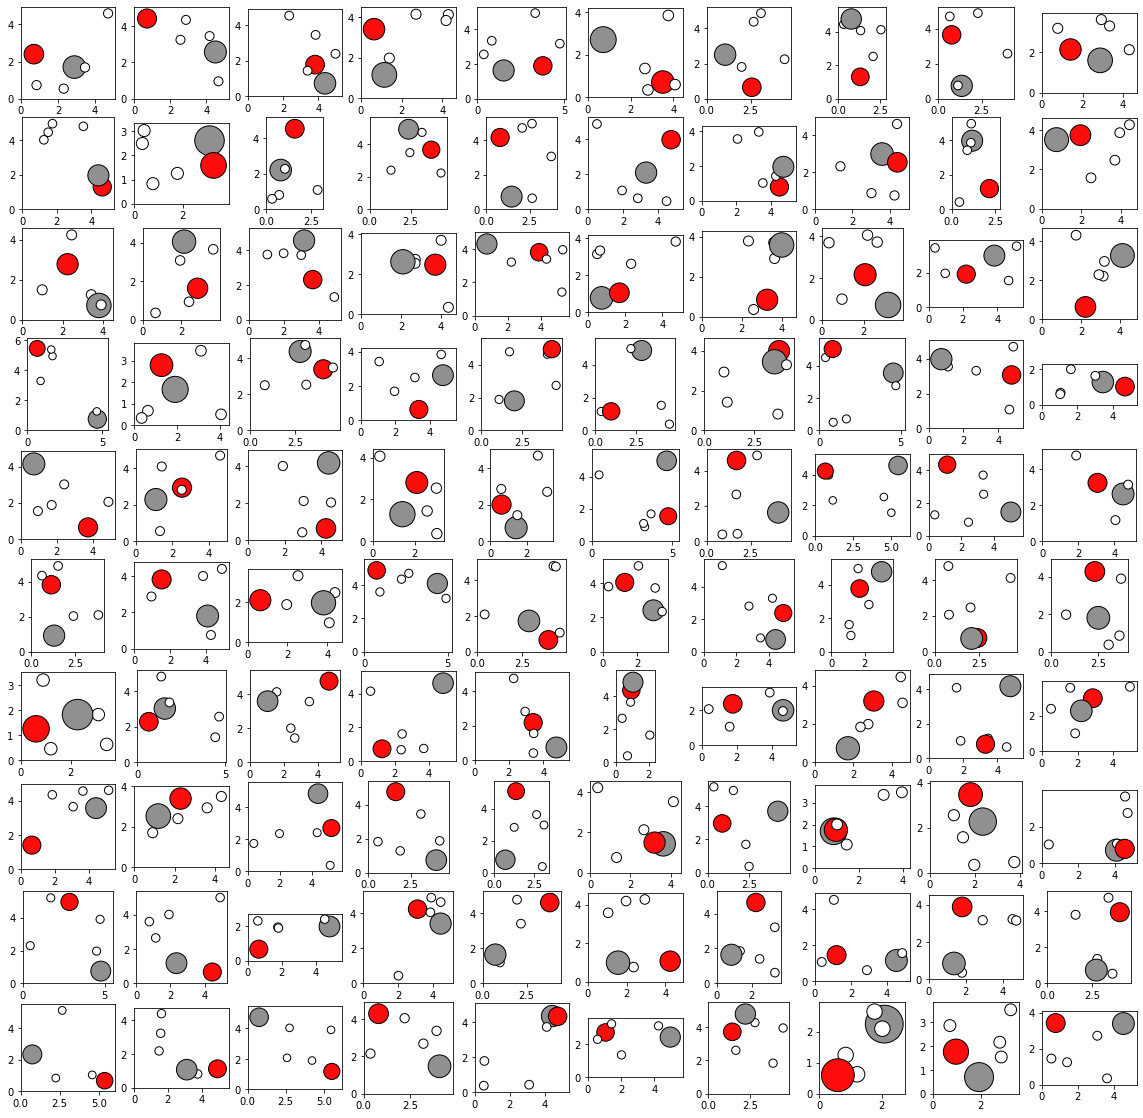

In [3]:
initConfig = Atoms(formula)
configs = [initConfig.copy() for _ in range(N)]

numAtoms = np.shape(initConfig.get_positions())[0]

for config in configs:
    randomPos = np.random.rand(numAtoms,3) * variation
    config.set_positions(randomPos)
    
    
print("100 examples:")
plt.figure(figsize=(20, 20))
I = 0
for i in range(10):
    for j in range(10):
        plt.subplot2grid((10,10), (i,j))
        plot_atoms(configs[I], radii=0.8)#rotation=('90x,45y,0z'))
        I = I + 1   

# Relaxing structures:

In [4]:
ditNotConverge = 0
convergedIndices = np.ones(len(configs)) == 1

i = 0

plotNotConverged = False

for config in configs:
    config.calc = utils.MLCalculator(model) # Assigning calculator
    
for config in configs:
    
    try:
        BFGS(config, logfile='trash.traj').run(fmax=0.05, steps=5000);
        config.center()
        i = i + 1
        
        
    except:
        ditNotConverge = ditNotConverge + 1
        
        convergedIndices[i] = False
        
        i = i + 1
            
        if(plotNotConverged == True):
            fig, ax = plt.subplots()
            plot_atoms(config, ax, radii=0.8)
            plt.show()
    
    # Printing progress:
    if(i%10 == 0):
        print(str(i) + '/' + str(len(configs)))

print('Done!')
print(str(ditNotConverge) + ' did not converge.')

10/120
20/120
30/120
40/120
50/120
60/120
70/120
80/120
90/120
100/120
110/120
120/120
Done!
2 did not converge.


## Deleting failed structures:

### Discarting non converged structures:

In [5]:
print(str(len(configs)) + ' configurations initialized.')

for i in range(len(configs)):
    if(False == convergedIndices[i]):
        del(configs[i])

print('Deleting non converged structures')
print(str(len(configs)) + ' configurations left.')

120 configurations initialized.
Deleting non converged structures
118 configurations left.


### Energi discard inputs:

Input maximum and minimum physical relevant configurational energies below:

-----------

In [6]:
Ehigh = 20 # discard energies above this value
Elow = -30 # Discard energies below this value

-----------

### Discarting non physical structures based on there energy:

Computing energies of: 118 configurations.
True
True
116 configurations left, due to non valid energies.


Text(0.5, 0, 'Structure number')

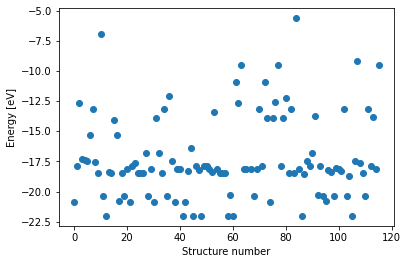

In [7]:
print('Computing energies of: ' + str(len(configs)) + ' configurations.')

valiedEnergyIndices = np.ones(len(configs))

for i in range(len(configs)):
    energy = configs[i].get_potential_energy()
    
    if(np.isnan(energy) or energy > Ehigh or energy < Elow):
        valiedEnergyIndices[i] = 0
        

for i in range(len(configs)):
    if(valiedEnergyIndices[i] == 0):
        print(valiedEnergyIndices[i] == 0)
    if(valiedEnergyIndices[i] == 0):
        del(configs[i])

# Computning filnal energies:
energies = np.zeros(len(configs))
for i in range(len(configs)):
    energies[i] = configs[i].get_potential_energy()
    
plt.scatter(np.arange(len(energies)),energies)


print(str(len(configs)) + ' configurations left, due to non valid energies.')
plt.ylabel('Energy [eV]')
plt.xlabel('Structure number')

### Plotting 100 remaning structures:

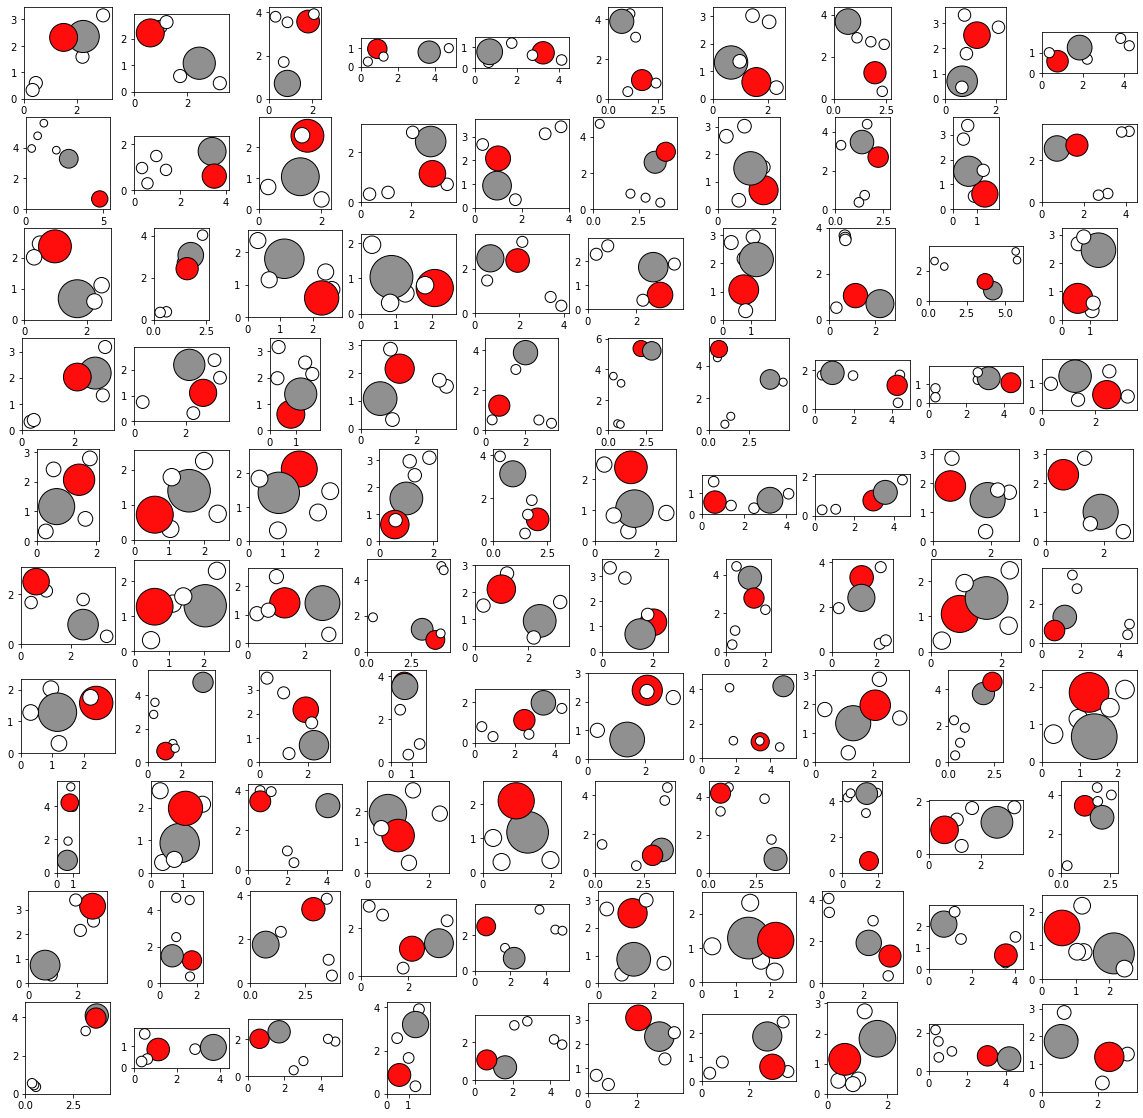

In [8]:
plt.figure(figsize=(20, 20))
I = 0
for i in range(10):
    for j in range(10):
        plt.subplot2grid((10,10), (i,j))
        
        try:
            plot_atoms(configs[I],radii=0.8)#rotation=('90x,45y,0z'))
            I = I + 1      
        
        except:
            break

# Saving obtained results:

In [10]:
saveConfigs = False

name = 'configsDec05-6-'
path = "configs_H4CO/"

if(saveConfigs == True):
    for i in range(len(configs)):
        write(path + name + str(i) + '.xyz', configs[i])
    print('Saved')
    
else:
    print('Not saved')

Not saved


# Importing configs:

In [11]:
loadConfigs = True # !!! if runing with out inporting, set this to False

path = "configs_H4CO/"

if(loadConfigs == True):
    configs = []
    dirList = os.listdir(path)
    for i in range(0, len(dirList)):
        newConfig = read(path + dirList[i])
        newConfig.calc = utils.MLCalculator(model) # Assigning calculator
        configs.append(newConfig)
        
    
    print(str(len(configs)) + ' elements loaded.')
    
else:
    print('Nothing loaded')

1401 elements loaded.


# RMSD

Computing RMSD values between all configurations and classifying the these according to the obtained values and threshold given below:

### RMSD inputs:

-----------------------------

In [12]:
RMSDthreshold = 0.8

-----------------------------

In [13]:
inBasket = np.ones(len(configs)) # Undefined configs

configLabels = np.zeros(len(configs))

for i in range(len(configs)):
    
    if(inBasket[i] == 1):
        
        for j in range(len(configs)):
            
            RMSD = np.ones(len(configs)) + RMSDthreshold
            RMSD[j] = kabsch_rmsd(configs[i].positions, configs[j].positions, translate=True)

            for ii in range(len(RMSD)):
                if(RMSD[ii] < RMSDthreshold):
                    if(inBasket[ii] == 1):
                        configLabels[ii] = i
                        inBasket[ii] = 0
    
    if(i%10 == 0):
        print(str(i) + '/' + str(len(configs)))

print('Done!')            

0/1401
10/1401
20/1401
30/1401
40/1401
50/1401
60/1401
70/1401
80/1401
90/1401
100/1401
110/1401
120/1401
130/1401
140/1401
150/1401
160/1401
170/1401
180/1401
190/1401
200/1401
210/1401
220/1401
230/1401
240/1401
250/1401
260/1401
270/1401
280/1401
290/1401
300/1401
310/1401
320/1401
330/1401
340/1401
350/1401
360/1401
370/1401
380/1401
390/1401
400/1401
410/1401
420/1401
430/1401
440/1401
450/1401
460/1401
470/1401
480/1401
490/1401
500/1401
510/1401
520/1401
530/1401
540/1401
550/1401
560/1401
570/1401
580/1401
590/1401
600/1401
610/1401
620/1401
630/1401
640/1401
650/1401
660/1401
670/1401
680/1401
690/1401
700/1401
710/1401
720/1401
730/1401
740/1401
750/1401
760/1401
770/1401
780/1401
790/1401
800/1401
810/1401
820/1401
830/1401
840/1401
850/1401
860/1401
870/1401
880/1401
890/1401
900/1401
910/1401
920/1401
930/1401
940/1401
950/1401
960/1401
970/1401
980/1401
990/1401
1000/1401
1010/1401
1020/1401
1030/1401
1040/1401
1050/1401
1060/1401
1070/1401
1080/1401
1090/1401
1100/1401
1

Printing found clasifications:

In [15]:
for i in range(len(configLabels)):
    print('Config no.: ' + str(configLabels[i]) + ' accurances: ' + str(len(configLabels[configLabels == i])))

Config no.: 0.0 accurances: 46
Config no.: 0.0 accurances: 0
Config no.: 2.0 accurances: 13
Config no.: 3.0 accurances: 6
Config no.: 4.0 accurances: 10
Config no.: 5.0 accurances: 3
Config no.: 6.0 accurances: 1
Config no.: 7.0 accurances: 24
Config no.: 0.0 accurances: 0
Config no.: 9.0 accurances: 24
Config no.: 10.0 accurances: 18
Config no.: 11.0 accurances: 25
Config no.: 12.0 accurances: 10
Config no.: 13.0 accurances: 3
Config no.: 14.0 accurances: 23
Config no.: 15.0 accurances: 9
Config no.: 2.0 accurances: 0
Config no.: 11.0 accurances: 0
Config no.: 18.0 accurances: 16
Config no.: 19.0 accurances: 2
Config no.: 20.0 accurances: 10
Config no.: 21.0 accurances: 1
Config no.: 22.0 accurances: 4
Config no.: 23.0 accurances: 16
Config no.: 24.0 accurances: 26
Config no.: 0.0 accurances: 0
Config no.: 26.0 accurances: 3
Config no.: 27.0 accurances: 14
Config no.: 28.0 accurances: 26
Config no.: 29.0 accurances: 4
Config no.: 30.0 accurances: 5
Config no.: 31.0 accurances: 11
Conf

Plotting RMSD for one configuration:

Text(0, 0.5, 'Density [Normalized units]')

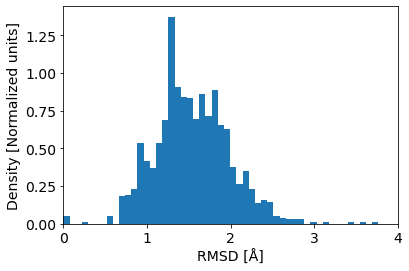

In [26]:
RMSD = np.ones(len(configs)) + RMSDthreshold
for i in range(len(configs)):

    RMSD[i] = kabsch_rmsd(configs[indexInvestagete].positions, configs[i].positions, translate=True)

indexInvestagete = 0 # selected configuration
view(configs[indexInvestagete])

font = {
        'size'   : 14}
plt.rc('font', **font)



plt.hist(RMSD,300,density = True);


plt.xlim([0,4])
#plt.ylim([0,50])
plt.xlabel('RMSD [Å]')
plt.ylabel('Density [Normalized units]')

# NEB

# Select reactant and product for neb calculation

----

In [27]:
R = configs[24] # reactant configuration
P = configs[10] # product configuration

# View configs:
view(P)
view(R)

---

## Running NEB:

In [28]:
atom_inters = [R.copy() for _ in range(10)] + [P]

# assining the model as calculator:
for atom_inter in atom_inters:
    atom_inter.calc = utils.MLCalculator(model)
    
neb = NEB(atom_inters,climb=True)
neb.interpolate(method="idpp")
relax_neb = NEBOptimizer(neb)
relax_neb.run(fmax=0.3, steps=500)

nebtools = NEBTools(atom_inters)
fit = nebtools.get_fit()

energies = fit.fit_energies.tolist()
path = fit.fit_path.tolist()

                   Step     Time         fmax
NEBOptimizer[ode]:    0 20:35:41       7.5644
NEBOptimizer[ode]:    1 20:35:41       7.0526
NEBOptimizer[ode]:    2 20:35:41       7.2484
NEBOptimizer[ode]:    3 20:35:41       7.3235
NEBOptimizer[ode]:    4 20:35:42       9.7364
NEBOptimizer[ode]:    5 20:35:42      12.4418
NEBOptimizer[ode]:    6 20:35:42      11.8795
NEBOptimizer[ode]:    7 20:35:42       3.7202
NEBOptimizer[ode]:    8 20:35:42       3.5936
NEBOptimizer[ode]:    9 20:35:42       3.3074
NEBOptimizer[ode]:   10 20:35:42       2.9566
NEBOptimizer[ode]:   11 20:35:42       2.7522
NEBOptimizer[ode]:   12 20:35:42       2.7143
NEBOptimizer[ode]:   13 20:35:42       2.7435
NEBOptimizer[ode]:   14 20:35:42       2.6043
NEBOptimizer[ode]:   15 20:35:42       2.3492
NEBOptimizer[ode]:   16 20:35:43       2.3537
NEBOptimizer[ode]:   17 20:35:43       2.3936
NEBOptimizer[ode]:   18 20:35:43       2.5032
NEBOptimizer[ode]:   19 20:35:43       2.8743
NEBOptimizer[ode]:   20 20:35:43  

C:\Users\Mathi\anaconda3\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: NEBTools.get_fit() is deprecated.  Please use ase.utils.forcecurve.fit_images(images).
  warnings.warn(warning)


## Plotting reaction path:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


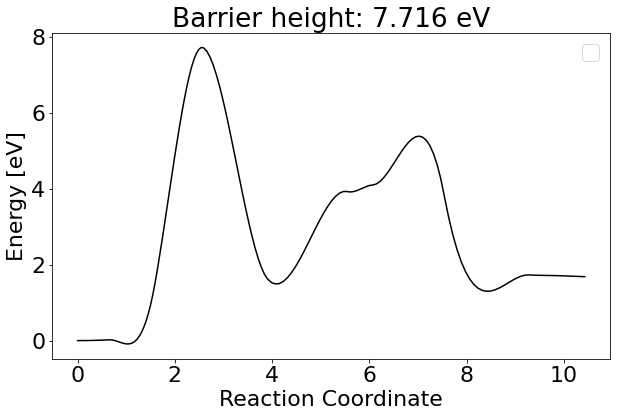

In [29]:
font = {
        'size'   : 22}
plt.rc('font', **font)

def mep_fig(path, energy):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(path, energy, color = 'black')
    #ax.grid()
    ax.set_title(f"Barrier height: {str(max(energy))[:5]} eV")
    ax.set_xlabel("Reaction Coordinate")
    ax.set_ylabel("Energy [eV]")
    ax.legend()
    #ax.set_ylim([5,5.5])
    return fig


mep_fig(path, energies)
plt.show()


## Plotting reaction images (configuration change along reaction path)

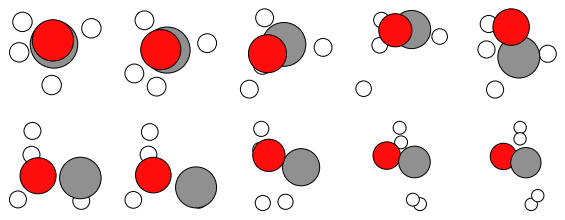

In [30]:
plt.figure(figsize=(10, 10))
I = 0
for i in range(2):
    for j in range(5):
        plt.subplot2grid((5,5), (i,j))
        plot_atoms(atom_inters[I],radii=0.8, rotation=('50x,-25y,-20z'))
        I = I + 1 
        plt.axis('off')
        
plt.show()

view(atom_inters[4])

#fig, ax = plt.subplots()
#plot_atoms(R, ax, radii=0.8)
#fig, ax = plt.subplots()
#plot_atoms(P, ax, radii=0.8)

# Plotting energy of all configurations

Text(0.5, 0, 'Reaction Coordinate [Å]')

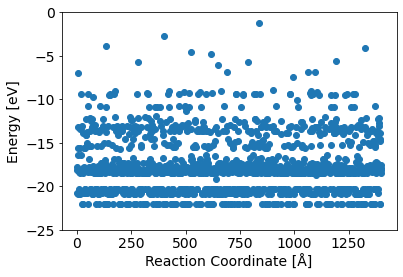

In [24]:
font = {
        'size'   : 14}
plt.rc('font', **font)

energies = np.zeros(len(configs))
for i in range(len(configs)):
    energies[i] = configs[i].get_potential_energy()

plt.scatter(np.arange(len(energies)),energies)
plt.ylim(-25,0)

plt.ylabel('Energy [eV]')
plt.xlabel("Reaction Coordinate [Å]")

## Selecting configurations based on energy:

In [18]:
upper = np.where(energies < -20)
lower = np.where(energies > -20.5)


np.intersect1d(lower, upper)

array([  10,   36,   39,   59,   65,   84,   90,   93,  112,  124,  126,
        129,  152,  153,  170,  178,  189,  198,  213,  214,  218,  221,
        225,  250,  252,  286,  288,  298,  314,  329,  355,  365,  372,
        377,  378,  388,  392,  419,  436,  444,  472,  473,  474,  485,
        491,  504,  506,  520,  530,  552,  553,  591,  599,  601,  619,
        628,  629,  636,  645,  658,  676,  680,  690,  695,  700,  701,
        717,  720,  723,  736,  746,  749,  755,  764,  772,  776,  783,
        810,  828,  838,  854,  860,  884,  893,  899,  902,  911,  931,
        932,  933,  947,  952,  957,  960,  972,  977,  988,  989,  995,
       1006, 1009, 1017, 1023, 1035, 1042, 1082, 1091, 1104, 1105, 1110,
       1114, 1130, 1131, 1143, 1150], dtype=int64)